In [7]:
import multiprocessing
import threading
from tqdm import tqdm
from niapy.algorithms.basic import (
    BatAlgorithm,
    FireflyAlgorithm,
    ParticleSwarmOptimization,
)
from niapy.algorithms import Algorithm
from niapy.problems import Problem
from niapy.problems.schwefel import Schwefel
from niapy.task import Task
import torch
from torch import nn
from torch.utils import data
from PIL import Image
import pandas as pd
import seaborn as sb
import sklearn.model_selection
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib import pyplot as plt
import os
import numpy as np
from numpy.random import default_rng
import pygad

from util.optimization_data import SingleRunData, PopulationData
from util.pop_diversity_metrics import PopDiversityMetric
from util.indiv_diversity_metrics import IndivDiversityMetric
from util.constants import RNG_SEED, DATASET_PATH, BATCH_SIZE, EPOCHS, POP_SIZE, MAX_ITER, NUM_RUNS

execute_training = False

In [2]:
def optimization(algorithm: Algorithm, task: Task, single_run_data: SingleRunData):
    r"""An adaptation of NiaPy Algorithm run method.

    Args:
        algorithm (Algorithm): Algorithm.
        task (Task): Task with pre configured parameters.
        single_run_data (SingleRunData): Instance for archiving optimization results
    """
    try:
        algorithm.callbacks.before_run()
        algorithm.rng = default_rng(seed=RNG_SEED)
        pop, fpop, params = algorithm.init_population(task)
        # reset seed to random
        algorithm.rng = default_rng()
        xb, fxb = algorithm.get_best(pop, fpop)
        while not task.stopping_condition():
            # save population data
            pop_data = PopulationData(
                population=np.array(pop), population_fitness=np.array(fpop)
            )
            pop_data.calculate_metrics(
                [
                    PopDiversityMetric.PDC,
                    PopDiversityMetric.PED,
                    PopDiversityMetric.PMD,
                    PopDiversityMetric.AAD,
                    PopDiversityMetric.PFSD,
                    PopDiversityMetric.PFMea,
                    PopDiversityMetric.PFMed,
                ],
                task.problem,
            )
            single_run_data.add_population(pop_data)
            algorithm.callbacks.before_iteration(pop, fpop, xb, fxb, **params)
            pop, fpop, xb, fxb, params = algorithm.run_iteration(
                task, pop, fpop, xb, fxb, **params
            )

            algorithm.callbacks.after_iteration(pop, fpop, xb, fxb, **params)
            task.next_iter()
        algorithm.callbacks.after_run()
        single_run_data.calculate_indiv_diversity_metrics(
            [
                IndivDiversityMetric.IDT,
                IndivDiversityMetric.ISI,
                IndivDiversityMetric.IFMea,
                IndivDiversityMetric.IFMed,
            ]
        )
        return xb, fxb * task.optimization_type.value
    except BaseException as e:
        if (
            threading.current_thread() is threading.main_thread()
            and multiprocessing.current_process().name == "MainProcess"
        ):
            raise e
        algorithm.exception = e
        return None, None

In [3]:
def optimization_worker(problem, algorithm, max_iter, run_index):
    r"""Single optimization run execution.

    Args:
        algorithm (Algorithm): Algorithm.
        problem (Problem): Optimization problem.
        max_iter (int): Optimization stopping condition.
        run_index (int): run index, used for file name.
    """
    task = Task(problem, max_iters=max_iter)

    single_run_data = SingleRunData(
        algorithm_name=algorithm.Name,
        algorithm_parameters=algorithm.get_parameters(),
        problem_name=problem.name(),
        max_iters=max_iter,
    )

    optimization(algorithm, task, single_run_data)
    single_run_data.export_to_json(
        os.path.join(
            DATASET_PATH, algorithm.Name[0], problem.name(), f"run_{run_index:05d}.json"
        )
    )

In [4]:
def optimization_runner(algorithm: Algorithm, problem: Problem, max_iter: int, runs: int, parallel_processing=False):
    r"""Optimization work splitter.

    Args:
        algorithm (Algorithm): Algorithm.
        problem (Problem): Optimization problem.
        max_iter (int): Optimization stopping condition.
        runs (int): Number of runs to execute.
        parallel_processing (bool): Execute optimization runs in parallel over multiple processes.
    """
    if parallel_processing:
        pool = []
        for r in range(runs):
            p = multiprocessing.Process(target=optimization_worker, args=(problem, algorithm, max_iter, r, ))
            p.start()
            pool.append(p)

        for p in pool:
            p.join()
    else:
        for r in range(runs):
            optimization_worker(problem, algorithm, max_iter, r)

In [9]:
for algorithm in [BatAlgorithm(population_size=POP_SIZE), FireflyAlgorithm(population_size=POP_SIZE), ParticleSwarmOptimization(population_size=POP_SIZE, c1=1.0, c2=1.0)]:
    problem = Schwefel()
    #optimization_runner(algorithm, problem, MAX_ITER, NUM_RUNS)

### Metrics comparison

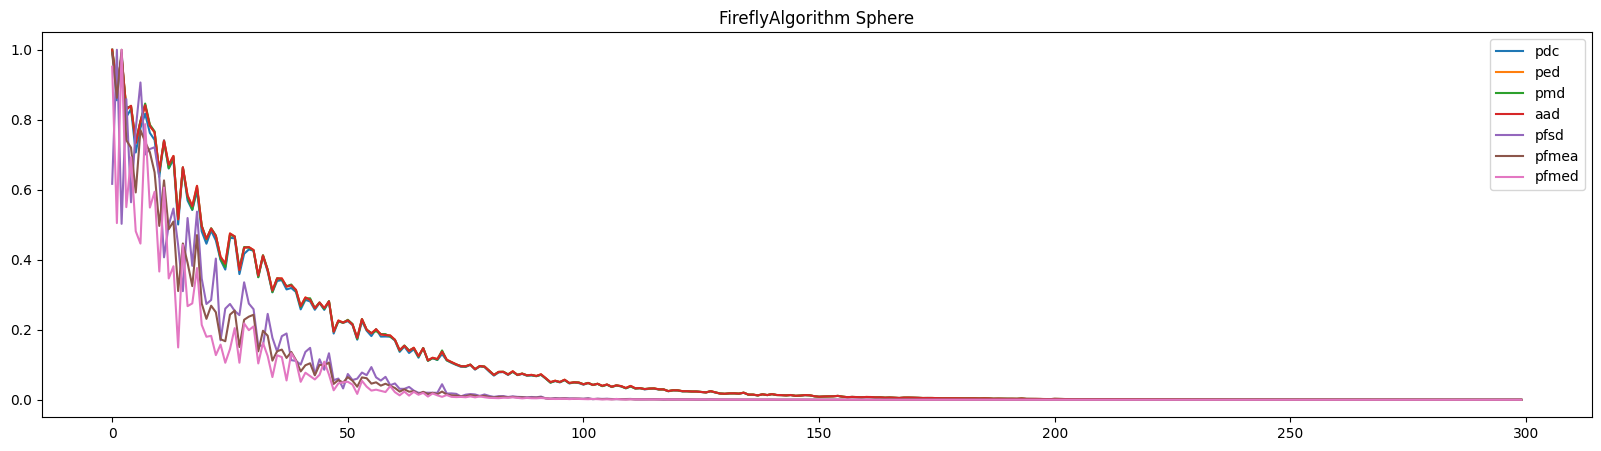

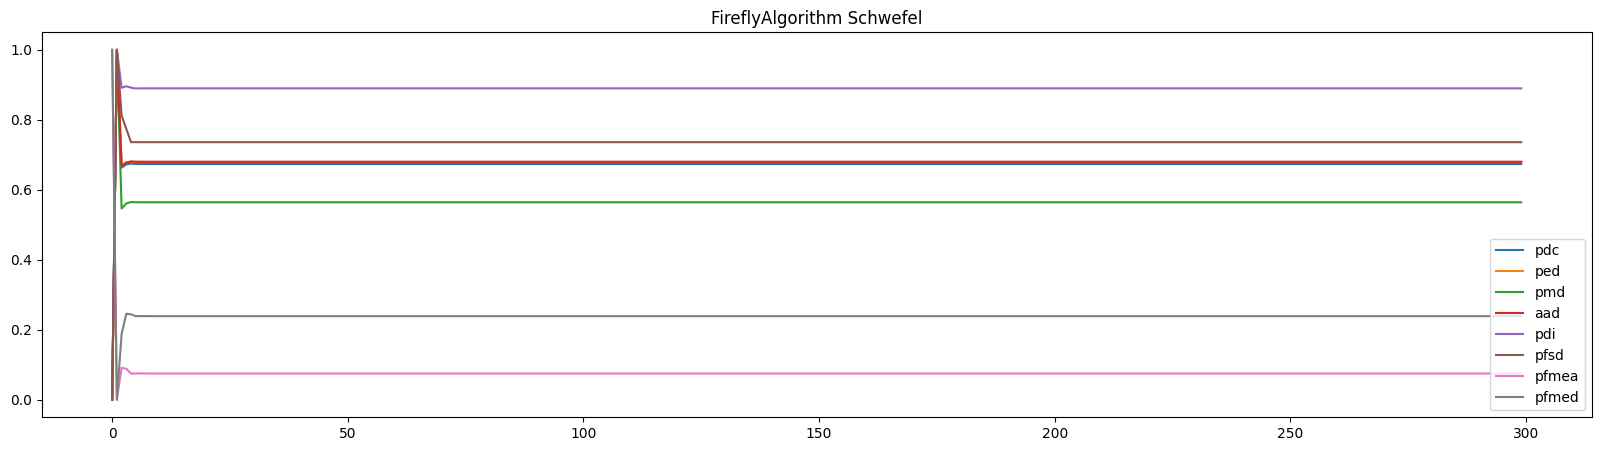

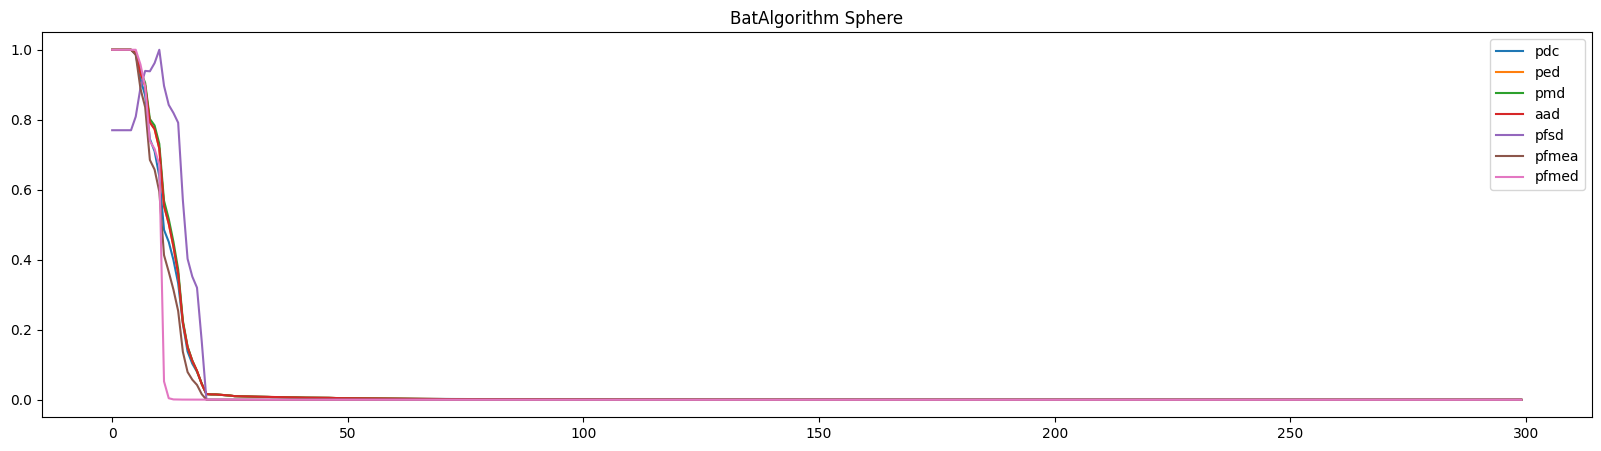

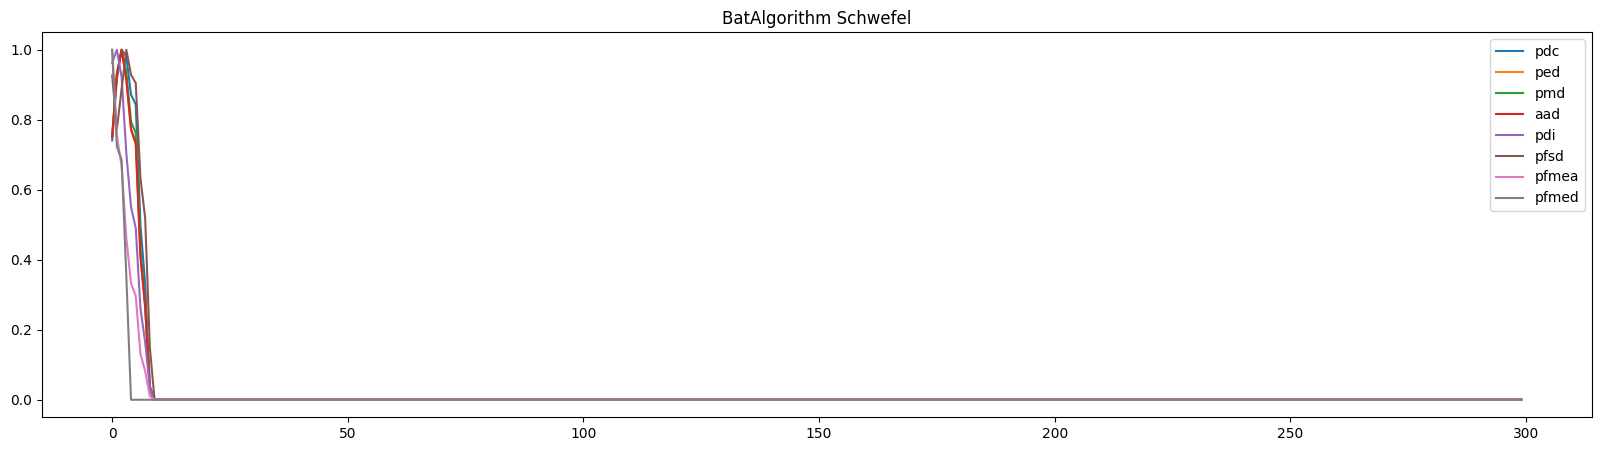

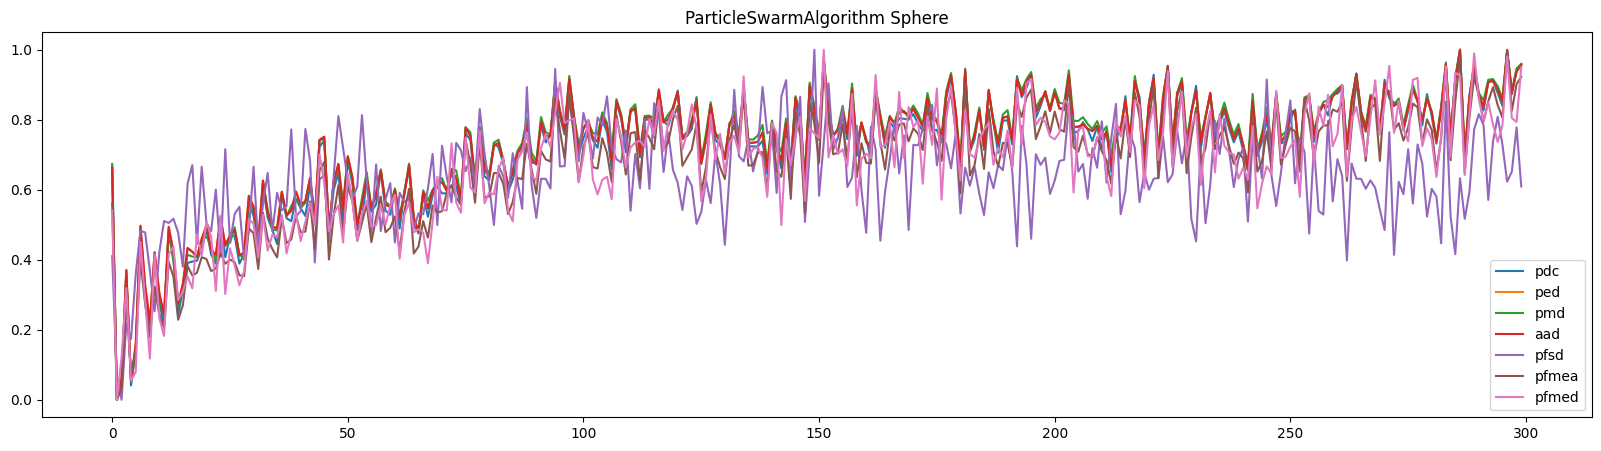

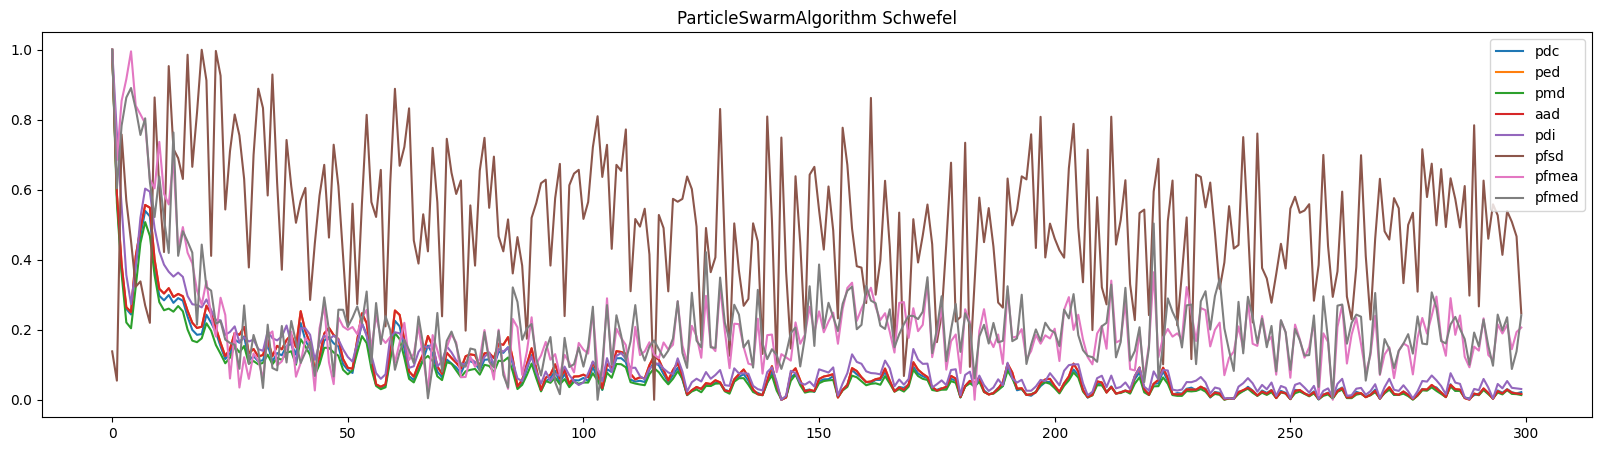

In [10]:
for algorithm in os.listdir(DATASET_PATH):
    for problem in os.listdir(os.path.join(DATASET_PATH, algorithm)):
        runs = os.listdir(os.path.join(DATASET_PATH, algorithm, problem))
        run_path = os.path.join(DATASET_PATH, algorithm, problem, runs[0])
        pop_metrics = SingleRunData.import_from_json(run_path).get_pop_diversity_metrics_values(normalize=True)
        pop_metrics.plot(title=" ".join([algorithm, problem]), figsize=(20,5))

### ML Data generation

In [ ]:
class data_generator(torch.utils.data.Dataset):
    def __init__(self, data_path_list, labels) -> None:
        super().__init__()
        self.data_path_list = data_path_list
        self.labels = labels

    def __len__(self):
        return len(self.data_path_list)

    def __getitem__(self, index):
        run = SingleRunData.import_from_json(self.data_path_list[index])
        pop_metrics = run.get_pop_diversity_metrics_values(normalize=True).to_numpy()
        indiv_metrics = run.get_indiv_diversity_metrics_values(
            normalize=True
        ).to_numpy()

        pca = PCA(n_components=indiv_metrics.shape[1])
        principal_components = pca.fit_transform(indiv_metrics).flatten()
        variance = pca.explained_variance_ratio_

        return (
            torch.from_numpy(pop_metrics).float(),
            torch.from_numpy(principal_components).float(),
            torch.tensor(self.labels.index(run.algorithm_name[0])),
        )

### Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, aux_input_dim, num_labels, hidden_dim=256, num_layers=3) -> None:
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.8
        )
        self.fc = nn.Linear(hidden_dim + aux_input_dim, num_labels)

    def forward(self, x, aux):
        lstm_out, (h_n, c_n) = self.lstm(x)
        features_0 = lstm_out[:, -1]
        features = torch.concat([features_0, aux], dim=1)
        out = self.fc(features)

        return features, out

### Data loading and preprocessing

In [ ]:
def get_data_loaders(val_size=0.2, test_size=0.2):
    r"""Get dataloaders for NN training, validation and testing.

    Args:
        val_size (float): Proportion of the dataset used for validation.
        test_size (float): Proportion of the dataset used for testing.

    Returns:
        Dataloader: train data loader
        Dataloader: validation data loader
        Dataloader: test data loader
        Array: class labels
    """
    dataset_paths = []
    labels = []
    for algorithm in os.listdir(DATASET_PATH):
        labels.append(algorithm)
        for problem in os.listdir(os.path.join(DATASET_PATH, algorithm)):
            for run in os.listdir(os.path.join(DATASET_PATH, algorithm, problem)):
                dataset_paths.append(os.path.join(DATASET_PATH, algorithm, problem, run))

    x_train, x_test = sklearn.model_selection.train_test_split(dataset_paths, test_size=test_size, shuffle=True, random_state=RNG_SEED)
    x_train, x_val = sklearn.model_selection.train_test_split(x_train, test_size=val_size/(1.0-test_size), shuffle=True, random_state=RNG_SEED)

    train_dataset = data_generator(x_train, labels)
    train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=os.cpu_count())

    val_dataset = data_generator(x_val, labels)
    val_data_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=os.cpu_count())

    test_dataset = data_generator(x_test, labels)
    test_data_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=os.cpu_count())

    return train_data_loader, val_data_loader, test_data_loader, labels

In [ ]:
def nn_train(model, train_data_loader, val_data_loader, epochs, loss_fn, optimizer, device, model_file_name, patience = 10, verbal=False):
    loss_values = []
    val_loss_values = []
    acc_values = []
    val_acc_values = []
    best_acc = 0.0
    trial_counter = 0

    for epoch in range(epochs):
        _loss_values = []
        _val_loss_values = []
        _acc_values = []
        _val_acc_values = []
            
        model.train()
        for batch in train_data_loader:
            pop_features, indiv_features, target = batch
            
            target = target.to(device)
            pop_features = pop_features.to(device)
            indiv_features = indiv_features.to(device)

            _, pred = model(pop_features, indiv_features)
            loss = loss_fn(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = torch.argmax(pred, dim=1).cpu().numpy()
            y_target = target.cpu().numpy()

            _acc_values.append(accuracy_score(y_target, y_pred))
            _loss_values.append(loss.item())

        model.eval()
        with torch.no_grad():
            for batch in val_data_loader:
                pop_features, indiv_features, target = batch
            
                target = target.to(device)
                pop_features = pop_features.to(device)
                indiv_features = indiv_features.to(device)

                _, pred = model(pop_features, indiv_features)
                loss = loss_fn(pred, target)

                y_pred = torch.argmax(pred, dim=1).cpu().numpy()
                y_target = target.cpu().numpy()

                _val_acc_values.append(accuracy_score(y_target, y_pred))
                _val_loss_values.append(loss.item())

        
        acc_values.append(np.mean(_acc_values))
        val_acc_values.append(np.mean(_val_acc_values))
        loss_values.append(np.mean(_loss_values))
        val_loss_values.append(np.mean(_val_loss_values))

        if verbal:
            print(f"epoch: {epoch + 1}, loss: {loss_values[-1] :.10f}, val_loss: {val_loss_values[-1] :.10f}, acc: {acc_values[-1] :.10f}, val_acc: {val_acc_values[-1] :.10f}")

        if val_acc_values[-1] > best_acc:
            trial_counter = 0
            best_acc = val_acc_values[-1]
            torch.save(model, model_file_name)
            if verbal:
                print(f"Saving model with accuracy: {best_acc :.10f}")
        else:
            trial_counter += 1
            if trial_counter >= patience:
                if verbal:
                    print(f"Early stopping after {epoch + 1} epochs")
                break

    if verbal:
        x = [*range(1, len(loss_values)+1)]
        plt.plot(x, loss_values, label="train loss")
        plt.plot(x, val_loss_values, label="val loss")
        plt.legend()
        plt.show()
        plt.plot(x, acc_values, label="train acc")
        plt.plot(x, val_acc_values, label="val acc")
        plt.legend()
        plt.show()

In [ ]:
def nn_test(model, test_data_loader, device, labels = None, show_classification_report=False):
    model.eval()

    y_pred = []
    y_target = []

    for batch in test_data_loader:
        pop_features, indiv_features, target = batch
            
        target = target.to(device)
        pop_features = pop_features.to(device)
        indiv_features = indiv_features.to(device)

        with torch.no_grad():
            _, pred = model(pop_features, indiv_features)
            
            y_pred.append(torch.argmax(pred).cpu().numpy())
            y_target.append(target.cpu().numpy()[0])

    
    if labels is not None:
        cf_matrix = confusion_matrix(y_target, y_pred)
        df_cm = pd.DataFrame(cf_matrix, index = [i for i in labels], columns = [i for i in labels])
        plt.figure(figsize = (12,7))
        sb.heatmap(df_cm, annot=True)

    if show_classification_report:
        print(classification_report(y_target, y_pred))
    
    return accuracy_score(y_target, y_pred)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
print("CPUs: ", os.cpu_count())

In [ ]:
train_data_loader, val_data_loader, test_data_loader, labels = get_data_loaders()

pop_features, indiv_features, target = next(iter(train_data_loader))
model = LSTM(np.shape(pop_features)[2], np.shape(indiv_features)[1], len(labels))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()
model_file_name = f"lstm_model.pt"

if execute_training:
    model.to(device)
    nn_train(model, train_data_loader, val_data_loader, EPOCHS, loss_fn, optimizer, device, model_file_name, verbal=True)
else:
    model = torch.load(model_file_name, map_location=torch.device(device))
    model.to(device)
    if os.path.exists('loss_plot.png'):
        loss_plot = np.asarray(Image.open('loss_plot.png'))
        plt.axis("off")
        plt.imshow(loss_plot)

In [ ]:
nn_test(model, test_data_loader, device, labels=labels, show_classification_report=True)

In [ ]:
def meta_ga_fitness_function(meta_ga, solution, solution_idx):
    algorithms = [
        FireflyAlgorithm(
            population_size=POP_SIZE,
            alpha=solution[0],
            beta0=solution[1],
            gamma=solution[2],
            theta=solution[3],
        ),
        BatAlgorithm(
            population_size=POP_SIZE,
            loudness=solution[4],
            pulse_rate=solution[5],
            alpha=solution[6],
            gamma=solution[7],
        ),
        ParticleSwarmOptimization(
            population_size=POP_SIZE, 
            c1=solution[8], 
            c2=solution[9], 
            w=solution[10]
        ),
    ]

    # gather optimization data
    for algorithm in algorithms:
        problem = Schwefel()
        optimization_runner(algorithm, problem, MAX_ITER, NUM_RUNS, parallel_processing=True)

    train_data_loader, val_data_loader, test_data_loader, labels = get_data_loaders()

    # model parameters
    pop_features, indiv_features, _ = next(iter(train_data_loader))
    model = LSTM(np.shape(pop_features)[2], np.shape(indiv_features)[1], len(labels))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    loss_fn = nn.CrossEntropyLoss()
    model_file_name = f"meta_ga_lstm_model.pt"

    model.to(device)
    nn_train(
        model=model,
        train_data_loader=train_data_loader,
        val_data_loader=val_data_loader,
        epochs=EPOCHS,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        model_file_name=model_file_name
    )
    
    model = torch.load(model_file_name, map_location=torch.device(device))
    model.to(device)
    accuracy = nn_test(model, test_data_loader, device)

    return 1.0 - accuracy

In [ ]:
gene_spaces = {
    "FA_gene_space": {
        "alpha": {"low": 0.01, "high": 1},
        "beta": {"low": 0.01, "high": 10},
        "gamma": {"low": 0.01, "high": 2},
        "theta": {"low": 0.01, "high": 2},
    },
    "BA_gene_space": {
        "loudness": {"low": 0.01, "high": 1},
        "puls_rate": {"low": 0.01, "high": 1},
        "alpha": {"low": 0.01, "high": 1},
        "gamma": {"low": 0.01, "high": 1},
    },
    "PSO_gene_space": {
        "c1": {"low": 0.01, "high": 1},
        "c2": {"low": 0.01, "high": 1},
        "w": {"low": 0.01, "high": 1},
    },
}

combined_gene_space = []
low_ranges = []
high_ranges = []
for gs in gene_spaces:
    for setting in gene_spaces[gs]:
        combined_gene_space.append(gene_spaces[gs][setting])
        low_ranges.append(gene_spaces[gs][setting]["low"])
        high_ranges.append(gene_spaces[gs][setting]["high"])


meta_ga = pygad.GA(
    num_generations=10,
    num_parents_mating=2,
    fitness_func=meta_ga_fitness_function,
    sol_per_pop=8,
    num_genes=len(combined_gene_space),
    init_range_low=low_ranges,
    init_range_high=high_ranges,
    parent_selection_type="sss",
    keep_parents=1,
    crossover_type="two_points",
    mutation_type="random",
    mutation_percent_genes=10,
    gene_space=combined_gene_space,
    save_best_solutions=True
)

meta_ga.run()

meta_ga.save("meta_ga")
solution, solution_fitness, solution_idx = meta_ga.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
